Load Packages
===============

In [1]:
%matplotlib inline
import os
import struct
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision

Load Data:
===============

In [2]:
Datapath = '../ALL_IDB2/img/'
listing = os.listdir(Datapath) 

In [3]:
from PIL import Image
import glob
TrainImages = torch.DoubleTensor(200,3072)
TrainLabels = torch.LongTensor(200)
TestImages = torch.DoubleTensor(60,3072)
TestLabels = torch.LongTensor(60)

img_no = 0
for file in listing:
    im=Image.open(Datapath + file)
    im = im.resize((32,32))
    im = np.array(im)
    im = np.reshape(im, 32*32*3)
    if img_no < 200:
        TrainImages[img_no] = torch.from_numpy(im)
        TrainLabels[img_no] = int(listing[img_no][6:7])
    else:
        TestImages[img_no - 200] = torch.from_numpy(im)
        TestLabels[img_no - 200] = int(listing[img_no][6:7])
    img_no = img_no + 1
            



In [4]:
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([200, 3072])
torch.Size([200])
torch.Size([60, 3072])
torch.Size([60])


In [5]:
use_gpu = torch.cuda.is_available()

Define the Autoencoder:
===============

In [6]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import copy


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU())
        self.decoder = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 32*32*3),
            nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
        
init_weights = copy.deepcopy(net.encoder[0].weight.data)

autoencoder (
  (encoder): Sequential (
    (0): Linear (3072 -> 100)
    (1): ReLU ()
    (2): Linear (100 -> 100)
    (3): ReLU ()
  )
  (decoder): Sequential (
    (0): Linear (100 -> 100)
    (1): ReLU ()
    (2): Linear (100 -> 3072)
    (3): ReLU ()
  )
)


Define Optimization Technique:
===============

In [7]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

Train Autoencoder:
===========

In [8]:
iterations = 30
BatchSize = 10
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]/BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        inputs = inputs/255
        if use_gpu:
            inputs = Variable(inputs).cuda()
        else:
            inputs = Variable(inputs)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data[0]
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,runningLoss/
                                                                (TrainImages.size()[0]/BatchSize)))
print('Finished Training')

At Iteration : 1 / 30  ;  Mean-Squared Error : 0.178079
At Iteration : 2 / 30  ;  Mean-Squared Error : 0.114012
At Iteration : 3 / 30  ;  Mean-Squared Error : 0.107599
At Iteration : 4 / 30  ;  Mean-Squared Error : 0.106694
At Iteration : 5 / 30  ;  Mean-Squared Error : 0.106540
At Iteration : 6 / 30  ;  Mean-Squared Error : 0.106437
At Iteration : 7 / 30  ;  Mean-Squared Error : 0.106370
At Iteration : 8 / 30  ;  Mean-Squared Error : 0.106354
At Iteration : 9 / 30  ;  Mean-Squared Error : 0.106182
At Iteration : 10 / 30  ;  Mean-Squared Error : 0.106160
At Iteration : 11 / 30  ;  Mean-Squared Error : 0.106154
At Iteration : 12 / 30  ;  Mean-Squared Error : 0.106152
At Iteration : 13 / 30  ;  Mean-Squared Error : 0.106150
At Iteration : 14 / 30  ;  Mean-Squared Error : 0.106087
At Iteration : 15 / 30  ;  Mean-Squared Error : 0.105951
At Iteration : 16 / 30  ;  Mean-Squared Error : 0.105920
At Iteration : 17 / 30  ;  Mean-Squared Error : 0.105827
At Iteration : 18 / 30  ;  Mean-Squared 

Encoder Weights Visualization:
=======================

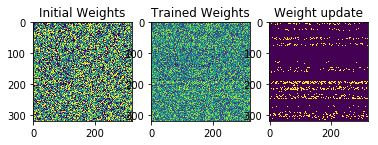

In [9]:
trained_weights = copy.deepcopy(net.encoder[0].weight.data)
init_weights = (1 + init_weights)*127.5
trained_weights = (1 + trained_weights)*127.5


if use_gpu:
    init_weights = init_weights.view(3,320,320).byte().cpu()
    trained_weights = trained_weights.view(3,320,320).byte().cpu()
else:
    init_weights = init_weights.view(3,320,320).byte()
    trained_weights = trained_weights.view(3,320,320).byte()

d_weights = init_weights - trained_weights 

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img)

plot=fig.add_subplot(1,3,2)
img = np.array(trained_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img)

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img)
plt.show()

In [10]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(100, 2),nn.LogSoftmax()))
print(net)
if use_gpu:
    net = net.double().cuda()
else:
    net = net.double()
cll_weights = copy.deepcopy(net[0][0].weight.data)
init_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)

Sequential (
  (0): Sequential (
    (0): Linear (3072 -> 100)
    (1): ReLU ()
    (2): Linear (100 -> 100)
    (3): ReLU ()
  )
  (classifier): Sequential (
    (0): Linear (100 -> 2)
    (1): LogSoftmax ()
  )
)


Define Optimizer:
================================

In [11]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

Train Classifier:
===========

In [12]:
iterations = 30
BatchSize = 10
for epoch in range(iterations):
    runningLoss = 0
    for i in range(TrainImages.size()[0]/BatchSize):
        inputs = torch.index_select(TrainImages,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).double()
        labels = torch.index_select(TrainLabels,0,torch.linspace(i*BatchSize,(i+1)*BatchSize - 1,steps=BatchSize)
                                  .long()).long()
        inputs = inputs/255
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        runningLoss += loss.data[0]
    inputs = TestImages.double()/255
    if use_gpu:
        inputs = Variable(inputs.cuda())
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
    else:
        inputs = Variable(inputs)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
    correct = 0
    total = 0
    total += TestLabels.size(0)
    correct += (predicted == TestLabels).sum()
    print('At Iteration: %d / %d  ;  Training Loss: %f ; Testing Acc: %f '%(epoch + 1,iterations,runningLoss/
                                                                            (TrainImages.size()[0]/
                                                                             BatchSize),(100 * correct/ float(total))))
print('Finished Training')

At Iteration: 1 / 30  ;  Training Loss: 0.738571 ; Testing Acc: 45.000000 
At Iteration: 2 / 30  ;  Training Loss: 0.689246 ; Testing Acc: 56.666667 
At Iteration: 3 / 30  ;  Training Loss: 0.675924 ; Testing Acc: 56.666667 
At Iteration: 4 / 30  ;  Training Loss: 0.665966 ; Testing Acc: 65.000000 
At Iteration: 5 / 30  ;  Training Loss: 0.663698 ; Testing Acc: 53.333333 
At Iteration: 6 / 30  ;  Training Loss: 0.609182 ; Testing Acc: 56.666667 
At Iteration: 7 / 30  ;  Training Loss: 0.579358 ; Testing Acc: 55.000000 
At Iteration: 8 / 30  ;  Training Loss: 0.619538 ; Testing Acc: 66.666667 
At Iteration: 9 / 30  ;  Training Loss: 0.563378 ; Testing Acc: 56.666667 
At Iteration: 10 / 30  ;  Training Loss: 0.535008 ; Testing Acc: 58.333333 
At Iteration: 11 / 30  ;  Training Loss: 0.537597 ; Testing Acc: 58.333333 
At Iteration: 12 / 30  ;  Training Loss: 0.504912 ; Testing Acc: 58.333333 
At Iteration: 13 / 30  ;  Training Loss: 0.519314 ; Testing Acc: 58.333333 
At Iteration: 14 / 30

Encoder Weights Visualization:
=======================

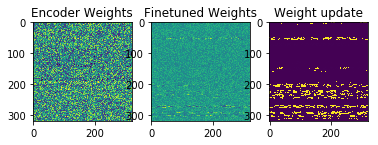

In [13]:
cll_weights_ft = copy.deepcopy(net[0][0].weight.data)
cll_weights = (1 + cll_weights)*127.5
cll_weights_ft = (1 + cll_weights_ft)*127.5

if use_gpu:
    cll_weights = cll_weights.view(3,320,320).byte().cpu()
    cll_weights_ft = cll_weights_ft.view(3,320,320).byte().cpu()
else:
    cll_weights = cll_weights.view(3,320,320).byte()
    cll_weights_ft = cll_weights_ft.view(3,320,320).byte()

d_weights = cll_weights - cll_weights_ft

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(cll_weights.numpy())[0]
plot.set_title('Encoder Weights')
imgplot = plt.imshow(img)

plot=fig.add_subplot(1,3,2)
img = np.array(cll_weights_ft.numpy())[0]
plot.set_title('Finetuned Weights')
imgplot = plt.imshow(img)

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img)
plt.show()

Classifier Weights Visualization:
=======================

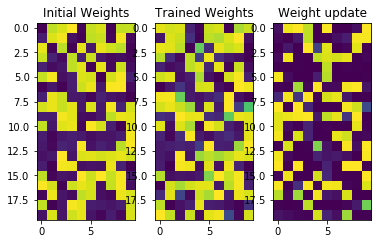

In [14]:
trained_classifier_weights = copy.deepcopy(net.classifier[0].weight.data)
init_classifier_weights = (1 + init_classifier_weights)*255
trained_classifier_weights = (1 + trained_classifier_weights)*255

if use_gpu:
    init_classifier_weights = init_classifier_weights.view(-1,20,10).byte().cpu()
    trained_classifier_weights = trained_classifier_weights.view(-1,20,10).byte().cpu()
else:
    init_classifier_weights = init_classifier_weights.view(-1,20,10).byte()
    trained_classifier_weights = trained_classifier_weights.view(-1,20,10).byte()

d_weights = init_classifier_weights - trained_classifier_weights

fig = plt.figure()
plot=fig.add_subplot(1,3,1)
img = np.array(init_classifier_weights.numpy())[0]
plot.set_title('Initial Weights')
imgplot = plt.imshow(img)

plot=fig.add_subplot(1,3,2)
img = np.array(trained_classifier_weights.numpy())[0]
plot.set_title('Trained Weights')
imgplot = plt.imshow(img)

plot=fig.add_subplot(1,3,3)
img = np.array(d_weights.numpy())[0]
plot.set_title('Weight update')
imgplot = plt.imshow(img)
plt.show()